# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains multiple tasks to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload both this ipynb file and the PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [46]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [47]:
#TODO

vocab = []

with open("wordlist.txt", "r") as file:
    for line in file:
        word = line.strip().lower()
        if 4 <= len(word) <= WORD_SIZE:  # filter words between length 4 and WORD_SIZE
            padded_word = word.ljust(WORD_SIZE, '_')  # pad with underscores
            vocab.append(padded_word)

# print(vocab[:10])

<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** (to write answers edit this cell)

1. Very short words does not contain enough information and also they do not need to be predicted since there are less than 3 number of characters. And the ambigiouty is high when the model tries to predict words by looking at only 1 or 2 characters. 

2. Fixed-length sequences make batching and training much more efficient.

3. To have too long words are also unnecessary since the use case of those words are very limited compared to the common words. Therefore using computation ppower to train the model for such rare cases are not necassary since they take both memory and time.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [48]:
def char_to_num(char):

    if char == '_':
        return 0
    
    num = ord(char) - ord('a') + 1
    return num
  

def num_to_char(num):

    if num == 0:
        return '_'
    
    char = chr(num + ord('a') - 1)    
    return(char)


def word_to_numlist(word):

    num_list = [char_to_num(c) for c in word]
    numlist = torch.tensor(num_list, dtype=torch.long)
    return(numlist)


def numlist_to_word(numlist):

    chars = [num_to_char(num.item()) for num in numlist]
    word =  ''.join(chars)
    return(word)



<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** (to write answers edit this cell)

The suggested claim is right because of following reasons

1. It imposes a false ordinal relationship between characters.
2. Characters are categorical, and numerical distance between indices can mislead the model into learning non-existent similarities.
3. The model may learn spurious patterns due to the artificial ordering of characters.


Embedding layer is a trainable lookup table that maps each integer to a dense vector of real numbers.

Purpose of embedding layer : 

1. Converts discrete character IDs into continuous-valued vectors.
2. Learns semantic relationships.
3. Avoids sparse one-hot vectors, reducing memory usage and improving learning efficiency.

## Section 2: Implementing the Autocomplete model

We will implement a RNN LSTM model. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [49]:
LEARNING_RATE = 0.005

In [50]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #TODO

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation
        self.embedding = nn.Embedding(alphabet_size, embed_dim)
        self.lstm = nn.LSTMCell(embed_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, alphabet_size)


    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        embedded = self.embedding(character)

        #2. Feed the embedded output to the LSTM cell
        hidden_state, cell_state = self.lstm(embedded, (hidden_state, cell_state))

        #3. Feed the LSTM output to the fully connected layer to obtain the output
        output = self.fc(hidden_state)

        #4. return the output, and both the hidden state and cell state from the LSTM cell output        
        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self, batch_size=1):
        device = next(self.parameters()).device
        h0 = torch.zeros(batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(batch_size, self.hidden_size).to(device)
        return h0, c0

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        for e in range(epochs):

            #TODO: Shuffle the vocab list the start of each epoch
            random.shuffle(vocab)
            num_iter = len(vocab) // batch_size + int(len(vocab) % batch_size != 0)


            for i in range(num_iter):

                #TODO: Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                optimizer.zero_grad()
                total_loss = 0
                vocab_batch = vocab[i*batch_size : (i+1)*batch_size]

                for word in vocab_batch:

                    #TODO: Initialize the hidden state and cell state at the start of each word.
                    hidden, cell = self.initial_state()
                    

                    #TODO: Convert the word into a tensor of number and create input and target from the word
                    word_tensor = word_to_numlist(word)

                    #Input will be the first WORD_SIZE - 1 charcters and target is the last WORD_SIZE - 1 charcters
                    input_seq = word_tensor[:-1]
                    target_seq = word_tensor[1:]

                    #Loop through each character (as a number) in the word
                    loss = 0
                    for c in range(WORD_SIZE - 1):
                        #TODO: Feed the cth character to the model (feedforward) and comput the loss (use cross entropy in torch)
                        input_char = input_seq[c].view(1)  # shape: (1,)
                        output, hidden, cell = self.forward(input_char, hidden, cell)
                        loss += criterion(output, target_seq[c].view(1))  # shape match

                    total_loss += loss
                    

                #TODO: Compute the average loss per word in the batch and perform backpropagation (.backward())
                avg_loss = total_loss / len(vocab_batch)
                avg_loss.backward()
                
                #TODO: Update model parameters using the optimizer
                optimizer.step()

                #Update the loss_log 
                loss_log.append(avg_loss.item())

            print("Epoch: ", e)

        #TODO Plot a graph of the variation of the loss.
        plt.plot(loss_log)
        plt.xlabel('Training Iteration')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Time')
        plt.grid(True)
        plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()
        completed_list = []

        def softmax(x):
            return torch.exp(x) / torch.sum(torch.exp(x), dim=1)

        #TODO: In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial 
        for literal in sample:

            literal = literal.ljust(WORD_SIZE, '_')
            input_tensor = word_to_numlist(literal)

            h0, c0 = self.initial_state()
            completed_word = []

            for c in range(WORD_SIZE - 1):
                input_char = input_tensor[c].view(1)  # shape: (1,)
                output, h0, c0 = self.forward(input_char, h0, c0)
                probs = softmax(output)
                next_char_idx = torch.multinomial(probs, 1).item()
                completed_word.append(num_to_char(next_char_idx))
            
            completed_list.append("".join(completed_word))

        return(completed_list)

## Section 3: Using and evaluating the model

(i) Initialize and train autocompleteModels using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can.

(ii) Evaluate it on different samples of partially filled in words to test your model. Eg: ["univ", "math", "neur", "engin"] etc.

(iii) Set your best model, to the variable best_model. This model will be tested against random inputs (3-4 starting strings of common English words). **This will be the main contributor for your score in this project**.

In [51]:
best_model = None


Training model 1 with config: {'embed_dim': 8, 'hidden_size': 32, 'num_layers': 1, 'lr': 0.1, 'batch_size': 512, 'epochs': 2}
Epoch:  0
Epoch:  1


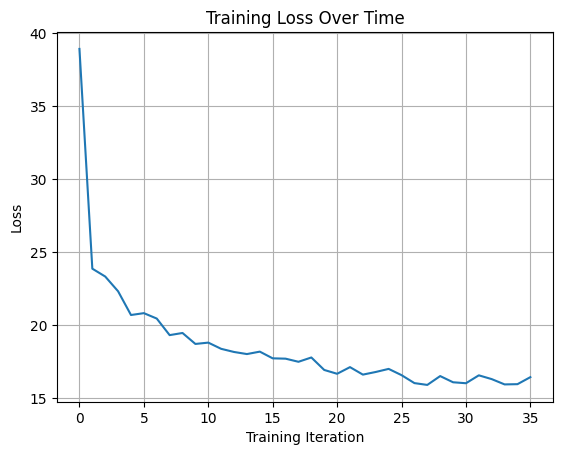

In [54]:
models = []
configs = [
    {"embed_dim": 8, "hidden_size": 32, "num_layers": 1, "lr": 0.1, "batch_size": 512, "epochs": 2},
    # {"embed_dim": 16, "hidden_size": 64, "num_layers": 1, "lr": 0.003, "batch_size": 5, "epochs": 25},
    # {"embed_dim": 8, "hidden_size": 128, "num_layers": 1, "lr": 0.001, "batch_size": 5, "epochs": 30},
]

for i, config in enumerate(configs):
    print(f"\nTraining model {i+1} with config: {config}")
    model = autocompleteModel(
        alphabet_size=27,
        embed_dim=config["embed_dim"],
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"]
    )
    global LEARNING_RATE
    LEARNING_RATE = config["lr"]
    model.trainModel(vocab, epochs=config["epochs"], batch_size=config["batch_size"])
    models.append(model)

In [55]:
best_model = models[0]

In [56]:
test_samples = ["univ", "math", "neur", "engin", "comp", "lang", "int", "arti", "tech", "mech"]

# Show predictions for each trained model
# for i, model in enumerate(models):
#     print(f"\nPredictions from model {i+1}:")
#     completed = model.autocomplete(test_samples)
#     for inp, out in zip(test_samples, completed):
#         print(f"{inp} -> {out}")

print(f"\nPredictions from best model:")
completed = models[0].autocomplete(test_samples)

for inp, out in zip(test_samples, completed):
    print(f"{inp} -> {out}")



Predictions from best model:
univ -> ncee________
math -> inta________
neur -> tnfu________
engin -> _vlie_______
comp -> enmu________
lang -> opys________
int -> lge_________
arti -> cuou________
tech -> unho________
mech -> oshe________
